In [12]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": False,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
})

In [2]:
import pandas as pd
from pathlib import Path

/nfs/home/jsewall/local/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [33]:
def binplot(ax, input_file, compute_app_eff, input_is_throughput, colordict=None):
    # Read in the CSV file as a Pandas DataFrame
    data = pd.read_csv(input_file, skipinitialspace=True, sep=',\s+', delimiter=',', na_values='X')
    # In the case of trailing whitespace, the X don't get converted.
    # This replaces anything starting with an X to a NaN
    data = data.replace(r'^X', np.nan, regex=True)

    # Make sure the data is all floating point
    data[list(data.columns[1:])] = data[list(data.columns[1:])].apply(pd.to_numeric)

    # Save a version where NaN is set to 0
    data_nona = data.fillna(float(0.0))

    if compute_app_eff:
        # Calculate application efficiency
        if not input_is_throughput:
            minimums = data.min(axis=1, skipna=True)
            for col in list(data.columns[1:]):
                data_nona[col] = minimums[:] / data_nona[col]
            data_nona = data_nona.replace([np.inf, -np.inf, np.nan], 0.0)
        else:
            maximums = data.max(axis=1, skipna=True)
            for col in list(data.columns[1:]):
                data_nona[col] = data_nona[col] / maximums[:] 
            data_nona = data_nona.replace([np.inf, -np.inf, np.nan], 0.0)
    else:
        for col in list(data.columns[1:]):
            data_nona[col] = data_nona[col] / 100.0
       
    # Group bar chart
    # First manually bin the data
    # First group should be zeros, then (0.0-10.0), [10.0-20.0), etc
    bins = np.arange(0,1.1,0.1, dtype=np.float)
    bins[0] = np.finfo(float).eps
    bins = np.append(np.zeros(1), bins)
    bar_data = {}
    for col in list(data_nona.columns[1:]):
      bar_data[col] = pd.value_counts(data_nona[col], sort=False, bins=bins) / data_nona[col].count() * 100.0
    if colordict:
        handles=pd.DataFrame(bar_data).plot.bar(ax=ax, color=colordict, legend=False)
    else:
        handles=pd.DataFrame(bar_data).plot.bar(ax=ax, legend='upper center')
    plt.ylabel('Frequency in %')
    plt.xlabel('Efficiency')
    plt.ylim([0.0,100.0])
    plt.grid(axis='y')
    # Rename the first bin
    locs, labels = plt.xticks()
    labels[0] = "Did not run"
    labels[1] = "(0.0, 0.1]"
    plt.xticks(locs, labels)
    
    labels=ax.get_xticklabels()
    ax.set_xticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")
    return handles.containers
    

In [14]:
qual_colormap = plt.get_cmap("tab10")
plat_order=["OpenMP", "Kokkos", "CUDA", "OpenACC", "OpenCL"]
import os
csv_root="../data/"
colordict ={}
for idx, name in enumerate(plat_order):
    colordict[name] = qual_colormap(idx)
patches = {}
for p in plat_order:
    patches[p] = Rectangle((0, 0), 1, 1, fc=colordict[p])

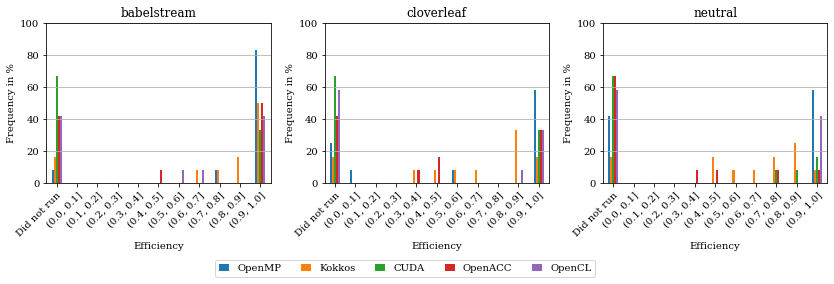

In [40]:
fig = plt.figure(figsize=(11.5, 3.5))
for i, appfile in enumerate(["babelstream.csv", "cloverleaf.csv", "neutral.csv"]):
    ax = fig.add_subplot(1,3,i+1)
    handles = binplot(ax, os.path.join(csv_root, appfile), True, "babelstream" in appfile, colordict)
    plt.title(Path(appfile).stem)
handles_names, handles_items = zip(*patches.items())
fig.legend(handles_items, handles_names, loc='upper left', ncol=5, handlelength=1.0, bbox_to_anchor=(0.25,0.0))
plt.tight_layout(pad=0.4,w_pad=1.5, h_pad=0.5)
plt.savefig("binned_chart_tiled.pdf", bbox_inches="tight")

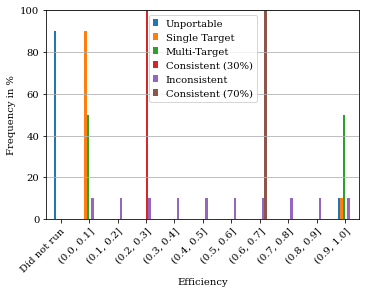

In [44]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1,1,1)
binplot(ax, os.path.join(csv_root, "synthetic.csv"), False, False) 
L=plt.legend()
texts = [ m.get_text().replace(r"\%", "%") for m in L.get_texts()]
plt.tight_layout(pad=0.4,w_pad=1.5, h_pad=0.5)
plt.legend(loc= "upper center", handlelength=0.5, labels=texts)
plt.savefig("binned_chart_synthetic.pdf", bbox_inches="tight")